In [1]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import set_config

set_config(display='diagram')

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.metrics import make_scorer, mean_squared_log_error, mean_squared_error

from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, StackingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.feature_selection import SelectPercentile, mutual_info_regression

# House Prices Challenge

<img src='https://wagon-public-datasets.s3.amazonaws.com/data-science-images/ML/kaggle-batch-challenge.png' width=600>

This is my entry to the Kaggle competition - [House Prices - Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)

**Challenge description:**

Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

# Load Data

Data overview:

- `train.csv` is the (1460 * 81) training set containing features and the target.
- `test.csv` is the (1459 * 80) testing set without the associated target.
- `sample_submission.csv` describes the format required for submission.
- `data_description.txt` describes the columns.


In [2]:
training_data = pd.read_csv('data/train.csv')
training_df = pd.DataFrame(training_data)
training_df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [3]:
#Splitting the data into X and y for the features and the target respectively
X = training_df.drop(columns=['SalePrice','Id'])
y = training_df['SalePrice']

# Baseline Model

## Initial feature overview

In [4]:
X.dtypes.value_counts()

object     43
int64      33
float64     3
dtype: int64

Storing the Series `feat_categorical_nunique` containing the number of **unique values** for each categorical feature in our training set.

In [5]:
feat_categorical_nunique = X.select_dtypes(include='object').nunique()
feat_categorical_nunique

MSZoning          5
Street            2
Alley             2
LotShape          4
LandContour       4
Utilities         2
LotConfig         5
LandSlope         3
Neighborhood     25
Condition1        9
Condition2        8
BldgType          5
HouseStyle        8
RoofStyle         6
RoofMatl          8
Exterior1st      15
Exterior2nd      16
MasVnrType        4
ExterQual         4
ExterCond         5
Foundation        6
BsmtQual          4
BsmtCond          4
BsmtExposure      4
BsmtFinType1      6
BsmtFinType2      6
Heating           6
HeatingQC         5
CentralAir        2
Electrical        5
KitchenQual       4
Functional        7
FireplaceQu       5
GarageType        6
GarageFinish      3
GarageQual        5
GarageCond        5
PavedDrive        3
PoolQC            3
Fence             4
MiscFeature       4
SaleType          9
SaleCondition     6
dtype: int64

🤔 If we were to `OneHotEncode` all categorical features, our feature matrix `X_preproc` would become pretty big and sparse, with almost 300 (highly correlated) features for only 1400 observations.

We can reduce the number of categorical features with 2 main strategies:
- **[Remove](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection)** features that bring too little explanation to our model.
- **[Ordinally encode](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html)** (instead of one-hot-encode) categorical features into integers. However this forces a notion of "order" (1>2>3...) that can be detrimental if not set properly.

Plotting the **histogram** of number of unique value per categorical feature to see which features would be good to cut in order to simplify the model.

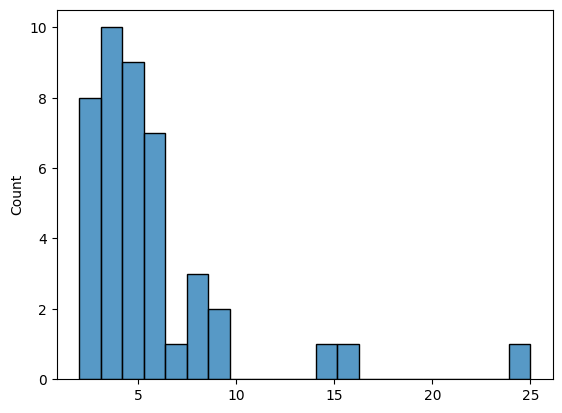

In [6]:
sns.histplot(data=feat_categorical_nunique);

To begin, we could remove all features that have 7 unique values or more, and one-hot-encode all the others.

In [7]:
#Storing names of columns to keep
feat_categorical_small = feat_categorical_nunique[feat_categorical_nunique < 7]
lst = list(feat_categorical_small.reset_index()['index'])
lst

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'BldgType',
 'RoofStyle',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleCondition']

## Baseline pipeline

### Preprocessing

Let's code a basic preprocessing pipeline.

For categorical features
- Simple-Impute with most frequent values
- One-Hot-Encode features that have less than 7 unique values
- Drop all others features


For numerical features
- Simple-Impute with mean
- Min-Max Scale 


In [8]:
# Impute numerical values:
num_transformer = Pipeline([('num_imputer', SimpleImputer(strategy='mean')),
                            ('scaler', MinMaxScaler())])

# Encode categorical values
cat_transformer = Pipeline([
    ('cat_imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore')),
])

# Parallelize "num_transformer" and "cat_transfomer"
preprocessor = ColumnTransformer(
    [('num_tr', num_transformer,
      make_column_selector(dtype_include=['int64', 'float64'])),
     ('cat_tr', cat_transformer, lst)],
    remainder='drop')

preproc_baseline = preprocessor
preproc_baseline

ColumnTransformer(transformers=[('num_tr',
                                 Pipeline(steps=[('num_imputer',
                                                  SimpleImputer()),
                                                 ('scaler', MinMaxScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x106572a10>),
                                ('cat_tr',
                                 Pipeline(steps=[('cat_imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['MSZonin...LotShape',
                                  'LandContour', 'Utilities', 'LotConfig',
                                  'LandSlope', 'BldgType', 'RoofStyle',
                                  'MasVnrType', 'ExterQual', 'ExterCond',
                                  'Foundation', 'BsmtQual', 'BsmtCond',
                                  'BsmtExposure', 'BsmtFinType1',
                                  'BsmtFinType2', 'Heating', 'HeatingQC',
                                  'CentralAir', 'Electrical', 'KitchenQual',
                                  'FireplaceQu', 'GarageType', 'GarageFinish',
                                  'GarageQual', 'GarageCond', 'PavedDrive', ...])])

In [9]:
processed_df = pd.DataFrame(preproc_baseline.fit_transform(X))
processed_df

,0,1,2,3,4,5,6,7,8,9,...,173,174,175,176,177,178,179,180,181,182
0,0.235294,0.150685,0.033420,0.666667,0.500,0.949275,0.883333,0.122500,0.125089,0.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.000000,0.202055,0.038795,0.555556,0.875,0.753623,0.433333,0.000000,0.173281,0.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.235294,0.160959,0.046507,0.666667,0.500,0.934783,0.866667,0.101250,0.086109,0.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.294118,0.133562,0.038561,0.666667,0.500,0.311594,0.333333,0.000000,0.038271,0.000000,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.235294,0.215753,0.060576,0.777778,0.500,0.927536,0.833333,0.218750,0.116052,0.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0.235294,0.140411,0.030929,0.555556,0.500,0.920290,0.833333,0.000000,0.000000,0.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1456,0.000000,0.219178,0.055505,0.555556,0.625,0.768116,0.633333,0.074375,0.139972,0.110583,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1457,0.294118,0.154110,0.036187,0.666667,1.000,0.500000,0.933333,0.000000,0.048724,0.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1458,0.000000,0.160959,0.039342,0.444444,0.625,0.565217,0.766667,0.000000,0.008682,0.698100,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### Add a simple model to the pipeline

In [10]:
#We will use a decision tree regressor for our baseline model.
pipe_baseline = make_pipeline(preprocessor, DecisionTreeRegressor())
pipe_baseline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_tr',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x106572a10>),
                                                 ('cat_tr',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknow...
                                                   'LotConfig', 'LandSlope',
                                                   'BldgType', 'RoofStyle',
                                                   'MasVnrType', 'ExterQual',
                                                   'ExterCond', 'Foundation',
                                                   'BsmtQual', 'BsmtCond',
                                                   'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'Heating',
                                                   'HeatingQC', 'CentralAir',
                                                   'Electrical', 'KitchenQual',
                                                   'FireplaceQu', 'GarageType',
                                                   'GarageFinish', 'GarageQual',
                                                   'GarageCond', 'PavedDrive', ...])])),
                ('decisiontreeregressor', DecisionTreeRegressor())])

### Cross-Validate

The Kaggle competition scores based on RMSLE (Root Mean Squared Least Logarithmic Error). We will need to create this metric manually.

We will create a scorer called `rmsle` that can be passed as a value for the `scoring` kwarg as below:
```python
cross_val_score(pipe_baseline, X, y, cv=5, scoring=rmsle)
```
We will also create the negative version `rmsle_neg` which is best when _maximized_. This will come handy later as a GridSearch tries to _maximize_ a score
```python
GridSearchCV(pipe_baseline, param_grid=..., cv=5, scoring=rmsle_neg)
```

$$\text{RMSLE}(y, \hat{y}) = \sqrt{\frac{1}{n_\text{samples}} \sum_{i=0}^{n_\text{samples} - 1} (\log_e (1 + y_i) - \log_e (1 + \hat{y}_i) )^2.}$$

In [11]:
rmsle = make_scorer(mean_squared_log_error,
                    greater_is_better=True,
                    squared=False)
rmsle_neg = make_scorer(mean_squared_log_error,
                        greater_is_better=False,
                        squared=False)

In [12]:
#Cross validating our baseline model on the RMSLE
score_baseline = cross_val_score(pipe_baseline, X, y, cv=5,
                                 scoring=rmsle).mean()
score_baseline

0.2140942158283195

### Baseline Prediction

In [13]:
#Importing test data to make predictions on.
test_data = pd.read_csv('data/test.csv')
test_df = pd.DataFrame(test_data)
X_test = test_df.drop(columns=['Id'])
X_test

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal


In [14]:
pipe_baseline.fit(X, y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_tr',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x106572a10>),
                                                 ('cat_tr',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknow...
                                                   'LotConfig', 'LandSlope',
                                                   'BldgType', 'RoofStyle',
                                                   'MasVnrType', 'ExterQual',
                                                   'ExterCond', 'Foundation',
                                                   'BsmtQual', 'BsmtCond',
                                                   'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'Heating',
                                                   'HeatingQC', 'CentralAir',
                                                   'Electrical', 'KitchenQual',
                                                   'FireplaceQu', 'GarageType',
                                                   'GarageFinish', 'GarageQual',
                                                   'GarageCond', 'PavedDrive', ...])])),
                ('decisiontreeregressor', DecisionTreeRegressor())])

In [15]:
y_pred_baseline = pipe_baseline.predict(X_test)
y_pred_baseline = pd.DataFrame(y_pred_baseline)
y_pred_baseline

,0
0,129000.0
1,157000.0
2,193000.0
3,168000.0
4,212000.0
...,...
1454,91500.0
1455,83000.0
1456,139000.0
1457,93500.0


❓ Finally, store your CSV ready to be submitted as `submission_baseline.csv` in the `data` folder. **Carefully read** the Kaggle required format and test it below (you don't need to submit this baseline online for now).

In [16]:
submission = pd.read_csv('data/sample_submission.csv').set_index('Id')

In [17]:
submission.SalePrice = np.array(y_pred_baseline)
submission.to_csv("data/submission_baseline.csv")

Our simple baseline model scored an RMSLE of 0.20892 upon submission to the competition. This will be our score to beat.

# Modeling

## Preprocessing

### Ordinal Encoding

In [18]:
feat_ordinal_dict = {
    #Considers "missing" as "neutral"
    "BsmtCond": ['missing', 'Po', 'Fa', 'TA', 'Gd'],
    "BsmtExposure": ['missing', 'No', 'Mn', 'Av', 'Gd'],
    "BsmtFinType1": ['missing', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    "BsmtFinType2": ['missing', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    "BsmtQual": ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
    "Electrical": ['missing', 'Mix', 'FuseP', 'FuseF', 'FuseA', 'SBrkr'],
    "ExterCond": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "ExterQual": ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
    "Fence": ['missing', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv'],
    "FireplaceQu": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "Functional": ['missing', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],
    "GarageCond": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "GarageFinish": ['missing', 'Unf', 'RFn', 'Fin'],
    "GarageQual": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "HeatingQC": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "KitchenQual": ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
    "LandContour": ['missing', 'Low', 'Bnk', 'HLS', 'Lvl'],
    "LandSlope": ['missing', 'Sev', 'Mod', 'Gtl'],
    "LotShape": ['missing', 'IR3', 'IR2', 'IR1', 'Reg'],
    "PavedDrive": ['missing', 'N', 'P', 'Y'],
    "PoolQC": ['missing', 'Fa', 'Gd', 'Ex'],
}

feat_ordinal = sorted(feat_ordinal_dict.keys())  #Sort alphabetically
feat_ordinal_values_sorted = [feat_ordinal_dict[i] for i in feat_ordinal]

encoder_ordinal = OrdinalEncoder(
    categories=feat_ordinal_values_sorted,
    dtype=np.int16,
    handle_unknown="use_encoded_value",
    unknown_value=-1  #Considers unknown values as worse than "missing"
)

preproc_ordinal = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"), encoder_ordinal,
    MinMaxScaler())

preproc_ordinal

Pipeline(steps=[('simpleimputer',
                 SimpleImputer(fill_value='missing', strategy='constant')),
                ('ordinalencoder',
                 OrdinalEncoder(categories=[['missing', 'Po', 'Fa', 'TA', 'Gd'],
                                            ['missing', 'No', 'Mn', 'Av', 'Gd'],
                                            ['missing', 'Unf', 'LwQ', 'Rec',
                                             'BLQ', 'ALQ', 'GLQ'],
                                            ['missing', 'Unf', 'LwQ', 'Rec',
                                             'BLQ', 'ALQ', 'GLQ'],
                                            ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
                                            ['missing', 'Mix', 'FuseP...
                                            ['missing', 'Po', 'Fa', 'TA', 'Gd',
                                             'Ex'],
                                            ['missing', 'Po', 'Fa', 'TA', 'Gd',
                                             'Ex'],
                                            ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
                                            ['missing', 'Low', 'Bnk', 'HLS',
                                             'Lvl'],
                                            ['missing', 'Sev', 'Mod', 'Gtl'],
                                            ['missing', 'IR3', 'IR2', 'IR1',
                                             'Reg'],
                                            ['missing', 'N', 'P', 'Y'],
                                            ['missing', 'Fa', 'Gd', 'Ex']],
                                dtype=<class 'numpy.int16'>,
                                handle_unknown='use_encoded_value',
                                unknown_value=-1)),
                ('minmaxscaler', MinMaxScaler())])

### Numerical Preprocessing

In [19]:
#Define numerical features
feat_numerical = sorted(
    X.drop(columns="MoSold").select_dtypes(
        include=["int64", "float64"]).columns)

preproc_numerical = make_pipeline(SimpleImputer(strategy="median"),
                                  MinMaxScaler())

### Nominal Encoding

In [20]:
#Define nominal features to one-hot-encode as the remaining ones (non numerical, non ordinal)
feat_nominal = sorted(
    list(set(X.columns) - set(feat_numerical) - set(feat_ordinal)))

preproc_nominal = make_pipeline(SimpleImputer(strategy="most_frequent"),
                                OneHotEncoder(handle_unknown="ignore"))

In [21]:
preproc = make_column_transformer((preproc_numerical, feat_numerical),
                                  (preproc_ordinal, feat_ordinal),
                                  (preproc_nominal, feat_nominal),
                                  remainder="drop")
preproc

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['1stFlrSF', '2ndFlrSF', '3SsnPorch',
                                  'BedroomAbvGr', 'BsmtFinSF1', 'BsmtFinSF2',
                                  'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF',
                                  'EnclosedPorch', 'Fireplaces', 'FullBath',
                                  'GarageArea', 'GarageCars', 'GarageYrBlt',
                                  'GrLi...
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Alley', 'BldgType', 'CentralAir',
                                  'Condition1', 'Condition2', 'Exterior1st',
                                  'Exterior2nd', 'Foundation', 'GarageType',
                                  'Heating', 'HouseStyle', 'LotConfig',
                                  'MSZoning', 'MasVnrType', 'MiscFeature',
                                  'MoSold', 'Neighborhood', 'RoofMatl',
                                  'RoofStyle', 'SaleCondition', 'SaleType',
                                  'Street', 'Utilities'])])

In [22]:
pd.DataFrame(preproc.fit_transform(X, y))

,0,1,2,3,4,5,6,7,8,9,...,217,218,219,220,221,222,223,224,225,226
0,0.119780,0.413559,0.0,0.375,0.125089,0.000000,0.333333,0.0,0.064212,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
1,0.212942,0.000000,0.0,0.375,0.173281,0.000000,0.000000,0.5,0.121575,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
2,0.134465,0.419370,0.0,0.375,0.086109,0.000000,0.333333,0.0,0.185788,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
3,0.143873,0.366102,0.0,0.375,0.038271,0.000000,0.333333,0.0,0.231164,0.492754,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
4,0.186095,0.509927,0.0,0.500,0.116052,0.000000,0.333333,0.0,0.209760,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0.142038,0.336077,0.0,0.375,0.000000,0.000000,0.000000,0.0,0.407962,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
1456,0.399036,0.000000,0.0,0.375,0.139972,0.110583,0.333333,0.0,0.252140,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
1457,0.195961,0.557869,0.0,0.500,0.048724,0.000000,0.000000,0.0,0.375428,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
1458,0.170721,0.000000,0.0,0.250,0.008682,0.698100,0.333333,0.0,0.000000,0.202899,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0


### Statistical Feature Selection

Our goal is to remove the least interesting features, to limit overfitting and shorten training time.  

- We will add a `SelectPercentile` filter to the end of our `preproc` pipeline.
- This will filter-out features that, - taken individually - least explain the target, according to the `mutual_info_regression`.

<details>
    <summary markdown='span'>🤔 What is mutual information?</summary>

- Mutual information is a *statistical* distance between two probability distributions.
- Correlation is a *linear* distance between two random variables.
- Mutual information is more general and measures the reduction of uncertainty in Y after observing X.
- On the other hand, if you already know you are working with variables that are smooth (like continuous numerical variables), sometimes correlation may tell you more about them, for instance if their relationship is monotonic.

In [23]:
preproc_transformer = make_column_transformer(
    (preproc_numerical,
     make_column_selector(dtype_include=["int64", "float64"])),
    (preproc_ordinal, feat_ordinal), (preproc_nominal, feat_nominal),
    remainder="drop")

preproc_selector = SelectPercentile(
    mutual_info_regression,
    percentile=80,  #Keep only 80% of all features
)

preproc = make_pipeline(preproc_transformer, preproc_selector)
preproc

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x12259bf70>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strat...
                                                   'Condition2', 'Exterior1st',
                                                   'Exterior2nd', 'Foundation',
                                                   'GarageType', 'Heating',
                                                   'HouseStyle', 'LotConfig',
                                                   'MSZoning', 'MasVnrType',
                                                   'MiscFeature', 'MoSold',
                                                   'Neighborhood', 'RoofMatl',
                                                   'RoofStyle', 'SaleCondition',
                                                   'SaleType', 'Street',
                                                   'Utilities'])])),
                ('selectpercentile',
                 SelectPercentile(percentile=80,
                                  score_func=<function mutual_info_regression at 0x11de595a0>))])

In [24]:
preproc.fit_transform(X, y).shape

(1460, 182)

## Target Engineering

We are asked to minimize the RMS**L**E. Therefore we can transform our target to directly predict its `log`.
- Check out the histogram of the target `y` below.
- Normally distributed variables should be easier to predict with linear or parametric models. 

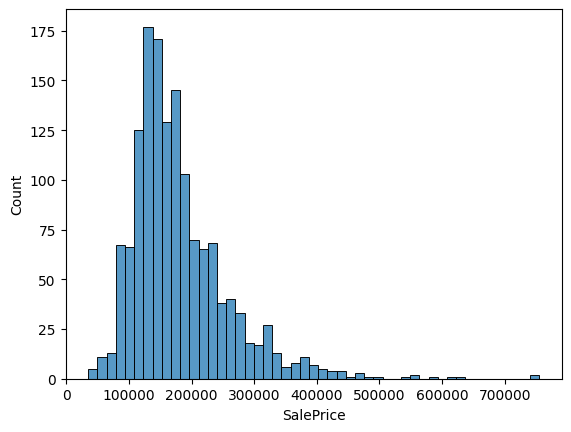

In [25]:
sns.histplot(y);

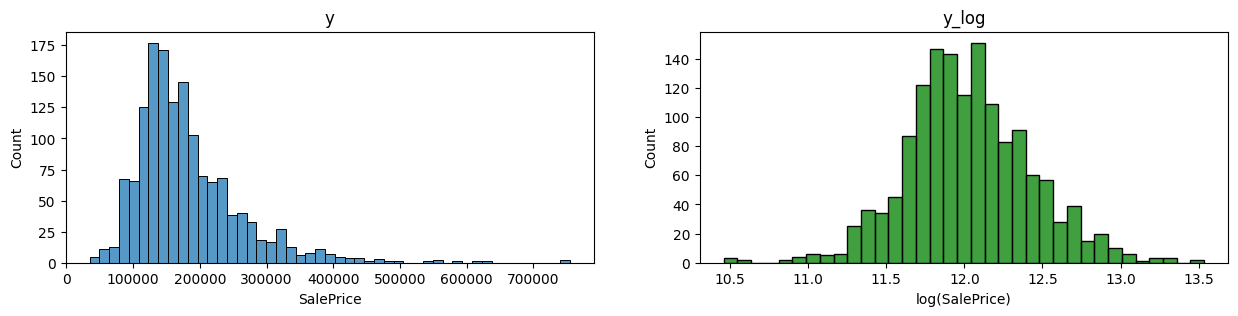

In [27]:
y_log = np.log(y)
plt.figure(figsize=(15, 3))
plt.subplot(1, 2, 1)
sns.histplot(y)
plt.title('y')
plt.subplot(1, 2, 2)
sns.histplot(y_log, color='green')
plt.xlabel("log(SalePrice)")
plt.title('y_log');

In [28]:
#Create a new scorer to minimize the error when predicting y_log
mse = make_scorer(mean_squared_error)

#Create a new scorer to maximize for GridSearch
mse_neg = make_scorer(mean_squared_error, greater_is_better=False)

## Model Iteration ♻

### Stacked Ensemble

Testing different regressors to use in our ensemble stacking model. Model selection was based upon the assumption that a diverse range of models with low correlation will provide the most robust predictions when stacked together.

In [29]:
#Elastic Net
model = ElasticNet()
pipe_net = make_pipeline(preproc, model)
cross_val_score(pipe_net, X, y_log, cv=5, scoring=mse).mean()

0.15963698451502384

In [30]:
# param_grid =  {'elasticnet__alpha': np.linspace(0.01, 1, 20),
#               'elasticnet__l1_ratio': np.linspace(0.01, 1, 20)}
# search_net = GridSearchCV(pipe_net, param_grid=param_grid, 
#                               cv=5, n_jobs=-1, verbose=2, scoring=mse_neg)

# search_net.fit(X, y_log);
# net_params = search_net.best_params_
# net_score = search_net.best_score_

In [31]:
net_params = {'alpha': 0.01, 'l1_ratio': 0.01}
net_score = -0.019914743040309307
print(net_params, net_score)

{'alpha': 0.01, 'l1_ratio': 0.01} -0.019914743040309307


In [32]:
#KNN Regressor
model = KNeighborsRegressor()
pipe_knn = make_pipeline(preproc, model)
cross_val_score(pipe_knn, X, y_log, cv=5, scoring=mse).mean()

0.04295414381190832

In [33]:
# param_grid =  {'kneighborsregressor__n_neighbors': [3,5,9,15,20,30]}
# search_knn = GridSearchCV(pipe_knn, param_grid=param_grid, 
#                               cv=5, n_jobs=-1, scoring=mse_neg)

# search_knn.fit(X, y_log);
# knn_params = search_knn.best_params_
# knn_score = search_knn.best_score_

In [34]:
knn_params = {'n_neighbors': 9}
knn_score = -0.04247054269337863
print(knn_params, knn_score)

{'n_neighbors': 9} -0.04247054269337863


In [35]:
#Support Vector Regressor
model = SVR()
pipe_svr = make_pipeline(preproc, model)
cross_val_score(pipe_svr, X, y_log, cv=5, scoring=mse).mean()

0.017420367396858014

In [36]:
# param_grid =  {'svr__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
#                 'svr__gamma': ['scale','auto'],
#                 'svr__C': [0.5, 0.7, 1, 2, 5, 10],
#                 'svr__epsilon': [0.01, 0.05, 0.1, 0.2, 0.5]}
# search_svr = GridSearchCV(pipe_svr, param_grid=param_grid, 
#                               cv=5, n_jobs=-1, verbose=2, scoring=mse_neg)

# search_svr.fit(X, y_log);
# svr_params = search_svr.best_params_
# svr_score = search_svr.best_score_

In [37]:
svr_params = {
    'svr__C': 1,
    'svr__epsilon': 0.01,
    'svr__gamma': 'scale',
    'svr__kernel': 'rbf'
}
svr_score = -0.01582681599064443
print(svr_params, svr_score)

{'svr__C': 1, 'svr__epsilon': 0.01, 'svr__gamma': 'scale', 'svr__kernel': 'rbf'} -0.01582681599064443


In [38]:
model = RandomForestRegressor()
pipe_rf = make_pipeline(preproc, model)
cross_val_score(pipe_rf, X, y_log, cv=5, scoring=mse).mean()

0.02028778923067417

In [39]:
# param_grid =  {'randomforestregressor__n_estimators': [10,20,50,100,150],
#                'randomforestregressor__min_samples_leaf': [1,10,20],
#                'randomforestregressor__min_samples_split': [2,5,10]}
# search_rf = GridSearchCV(pipe_rf, param_grid=param_grid, 
#                               cv=5, n_jobs=-1, verbose=2, scoring=mse_neg)

# search_rf.fit(X, y_log);
# rf_params = search_rf.best_params_
# rf_score = search_rf.best_score_

In [40]:
rf_params = {
    'randomforestregressor__min_samples_leaf': 1,
    'randomforestregressor__min_samples_split': 2,
    'randomforestregressor__n_estimators': 150
}
rf_score = -0.01993324593044949
print(rf_params, rf_score)

{'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__n_estimators': 150} -0.01993324593044949


In [41]:
model = GradientBoostingRegressor()
pipe_gb = make_pipeline(preproc, model)
cross_val_score(pipe_gb, X, y_log, cv=5, scoring=mse).mean()

0.01564869652292667

In [43]:
# param_grid = {
#     'gradientboostingregressor__n_estimators': [3000, 2000, 1000],
#     'gradientboostingregressor__learning_rate': [0.05, 0.5, 1],
#     'gradientboostingregressor__max_depth': [4,8],
#     'gradientboostingregressor__max_features': ['sqrt'],
#     'gradientboostingregressor__min_samples_leaf': [15,20],
#     'gradientboostingregressor__min_samples_split': [10,20],
#     'gradientboostingregressor__loss': ['huber']
# }
# search_gb = GridSearchCV(pipe_gb,
#                          param_grid=param_grid,
#                          cv=5,
#                          n_jobs=-1,
#                          verbose=2,
#                          scoring=mse_neg)

# search_gb.fit(X, y_log)
# gb_params = search_gb.best_params_
# gb_score = search_gb.best_score_

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] END gradientboostingregressor__learning_rate=0.05, gradientboostingregressor__loss=huber, gradientboostingregressor__max_depth=4, gradientboostingregressor__max_features=sqrt, gradientboostingregressor__min_samples_leaf=15, gradientboostingregressor__min_samples_split=10, gradientboostingregressor__n_estimators=3000; total time=  25.0s
[CV] END gradientboostingregressor__learning_rate=0.05, gradientboostingregressor__loss=huber, gradientboostingregressor__max_depth=4, gradientboostingregressor__max_features=sqrt, gradientboostingregressor__min_samples_leaf=15, gradientboostingregressor__min_samples_split=10, gradientboostingregressor__n_estimators=2000; total time=  17.6s
[CV] END gradientboostingregressor__learning_rate=0.05, gradientboostingregressor__loss=huber, gradientboostingregressor__max_depth=4, gradientboostingregressor__max_features=sqrt, gradientboostingregressor__min_samples_leaf=15, gradientboostingregress

[CV] END gradientboostingregressor__learning_rate=0.05, gradientboostingregressor__loss=huber, gradientboostingregressor__max_depth=4, gradientboostingregressor__max_features=sqrt, gradientboostingregressor__min_samples_leaf=15, gradientboostingregressor__min_samples_split=10, gradientboostingregressor__n_estimators=3000; total time=  24.2s
[CV] END gradientboostingregressor__learning_rate=0.05, gradientboostingregressor__loss=huber, gradientboostingregressor__max_depth=4, gradientboostingregressor__max_features=sqrt, gradientboostingregressor__min_samples_leaf=15, gradientboostingregressor__min_samples_split=10, gradientboostingregressor__n_estimators=3000; total time=  24.1s
[CV] END gradientboostingregressor__learning_rate=0.05, gradientboostingregressor__loss=huber, gradientboostingregressor__max_depth=4, gradientboostingregressor__max_features=sqrt, gradientboostingregressor__min_samples_leaf=15, gradientboostingregressor__min_samples_split=10, gradientboostingregressor__n_estimat

[CV] END gradientboostingregressor__learning_rate=0.05, gradientboostingregressor__loss=huber, gradientboostingregressor__max_depth=4, gradientboostingregressor__max_features=sqrt, gradientboostingregressor__min_samples_leaf=15, gradientboostingregressor__min_samples_split=10, gradientboostingregressor__n_estimators=3000; total time=  24.5s
[CV] END gradientboostingregressor__learning_rate=0.05, gradientboostingregressor__loss=huber, gradientboostingregressor__max_depth=4, gradientboostingregressor__max_features=sqrt, gradientboostingregressor__min_samples_leaf=15, gradientboostingregressor__min_samples_split=10, gradientboostingregressor__n_estimators=2000; total time=  17.6s
[CV] END gradientboostingregressor__learning_rate=0.05, gradientboostingregressor__loss=huber, gradientboostingregressor__max_depth=4, gradientboostingregressor__max_features=sqrt, gradientboostingregressor__min_samples_leaf=15, gradientboostingregressor__min_samples_split=10, gradientboostingregressor__n_estimat

[CV] END gradientboostingregressor__learning_rate=0.05, gradientboostingregressor__loss=huber, gradientboostingregressor__max_depth=4, gradientboostingregressor__max_features=sqrt, gradientboostingregressor__min_samples_leaf=15, gradientboostingregressor__min_samples_split=10, gradientboostingregressor__n_estimators=3000; total time=  25.1s
[CV] END gradientboostingregressor__learning_rate=0.05, gradientboostingregressor__loss=huber, gradientboostingregressor__max_depth=4, gradientboostingregressor__max_features=sqrt, gradientboostingregressor__min_samples_leaf=15, gradientboostingregressor__min_samples_split=10, gradientboostingregressor__n_estimators=2000; total time=  17.2s
[CV] END gradientboostingregressor__learning_rate=0.05, gradientboostingregressor__loss=huber, gradientboostingregressor__max_depth=4, gradientboostingregressor__max_features=sqrt, gradientboostingregressor__min_samples_leaf=15, gradientboostingregressor__min_samples_split=10, gradientboostingregressor__n_estimat

In [45]:
gb_params = {
    'gradientboostingregressor__learning_rate': 0.05,
    'gradientboostingregressor__loss': 'huber',
    'gradientboostingregressor__max_depth': 4,
    'gradientboostingregressor__max_features': 'sqrt',
    'gradientboostingregressor__min_samples_leaf': 15,
    'gradientboostingregressor__min_samples_split': 10,
    'gradientboostingregressor__n_estimators': 2000
}
gb_score = -0.015114576190039048
print(gb_params, gb_score)

{'gradientboostingregressor__learning_rate': 0.05, 'gradientboostingregressor__loss': 'huber', 'gradientboostingregressor__max_depth': 4, 'gradientboostingregressor__max_features': 'sqrt', 'gradientboostingregressor__min_samples_leaf': 15, 'gradientboostingregressor__min_samples_split': 10, 'gradientboostingregressor__n_estimators': 2000} -0.015114576190039048


The KNN performed the worst out of the models tested and is therefore left out of the ensemble.

In [55]:
ensemble = StackingRegressor(estimators=[
    ("rf",
     RandomForestRegressor(min_samples_leaf=1,
                           min_samples_split=2,
                           n_estimators=150)),
    ("gb",
     GradientBoostingRegressor(learning_rate=0.05,
                               loss='huber',
                               max_depth=4,
                               max_features='sqrt',
                               min_samples_leaf=15,
                               min_samples_split=10,
                               n_estimators=2000)),
    ("svr", 
     SVR(C=1, epsilon=0.01, gamma='scale', kernel='rbf')),
    ("net", 
     ElasticNet(alpha=0.01, l1_ratio=0.01)),
],
                             final_estimator=LinearRegression(),
                             cv=5)

In [56]:
pipe = make_pipeline(preproc, ensemble)
pipe

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('pipeline-1',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('minmaxscaler',
                                                                                    MinMaxScaler())]),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x12259bf70>),
                                                                  ('pipeline-2',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImpute...
                 StackingRegressor(cv=5,
                                   estimators=[('rf',
                                                RandomForestRegressor(n_estimators=150)),
                                               ('gb',
                                                GradientBoostingRegressor(learning_rate=0.05,
                                                                          loss='huber',
                                                                          max_depth=4,
                                                                          max_features='sqrt',
                                                                          min_samples_leaf=15,
                                                                          min_samples_split=10,
                                                                          n_estimators=2000)),
                                               ('svr', SVR(C=1, epsilon=0.01)),
                                               ('net',
                                                ElasticNet(alpha=0.01,
                                                           l1_ratio=0.01))],
                                   final_estimator=LinearRegression()))])

In [57]:
%%time
score = cross_val_score(pipe, X, y_log, cv=5, scoring=mse).mean()
score

CPU times: user 5min 12s, sys: 2.71 s, total: 5min 15s
Wall time: 5min 17s


0.014138466045250625

0.014452694972433771

In [58]:
pipe.fit(X,y_log)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('pipeline-1',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('minmaxscaler',
                                                                                    MinMaxScaler())]),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x12259bf70>),
                                                                  ('pipeline-2',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImpute...
                 StackingRegressor(cv=5,
                                   estimators=[('rf',
                                                RandomForestRegressor(n_estimators=150)),
                                               ('gb',
                                                GradientBoostingRegressor(learning_rate=0.05,
                                                                          loss='huber',
                                                                          max_depth=4,
                                                                          max_features='sqrt',
                                                                          min_samples_leaf=15,
                                                                          min_samples_split=10,
                                                                          n_estimators=2000)),
                                               ('svr', SVR(C=1, epsilon=0.01)),
                                               ('net',
                                                ElasticNet(alpha=0.01,
                                                           l1_ratio=0.01))],
                                   final_estimator=LinearRegression()))])

In [61]:
y_pred = pipe.predict(X_test)
y_pred = pd.DataFrame(y_pred)
y_pred = y_pred.apply(lambda x : np.exp(x))
y_pred


,0
0,122464.804308
1,152316.892001
2,185384.789009
3,196170.828870
4,186545.124278
...,...
1454,80658.903570
1455,78486.267072
1456,164058.393829
1457,106922.155800


# 🏅FINAL SUBMISSION

In [62]:
submission = pd.read_csv('data/sample_submission.csv').set_index('Id')
submission.SalePrice = np.array(y_pred)
submission.to_csv("data/ensemble_submission.csv")

The stacked ensemble model scored an RMSLE of 0.12295 upon submission to the competition. An improvement on our baseline score.